<a href="https://colab.research.google.com/github/petroff1983/ai_seller/blob/main/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB_%22%D0%9D%D0%B5%D0%B9%D1%80%D0%BE_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%BD%D0%B8%D0%BA_%D0%94%D0%95%D0%9B%D0%9E%D0%A2%D0%95%D0%A5_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Нейро-продажник** для компании по строительству домов https://deloteh.ru
*Задача: Создать нейро-продажника для проведения переговоров с клиентом по продаже ему услуги по строительству дома, чтобы клиент не догадался что с ним общается машина. Основная задача нейропродажника взять контакты потенциального покупателя(превратить его в лида)*

**Результат: Разработан нейросотрудник - менеджер по продажам, который проактивно продает продукт в диалоге с клиентом и получает от него номер телефона для звонка менеджера.**

Функции нейросотрудника:

- поддержание диалога с клиентом,

- проактивное выявление потребностей клиента,

- закрытие возражений клиента,

- проведение презентации услуги,

- получение контактов клиента для дальнейшего взаимодействия с экспертом по строительству домов

- согласование времени звонка от менеджера для уточнения деталей

База знаний: https://docs.google.com/document/d/1U0779lu3NpZDTiVSLHYEHJ79HDI-7txUuNZ5WhI1HR8.

## Общая структура алгоритма

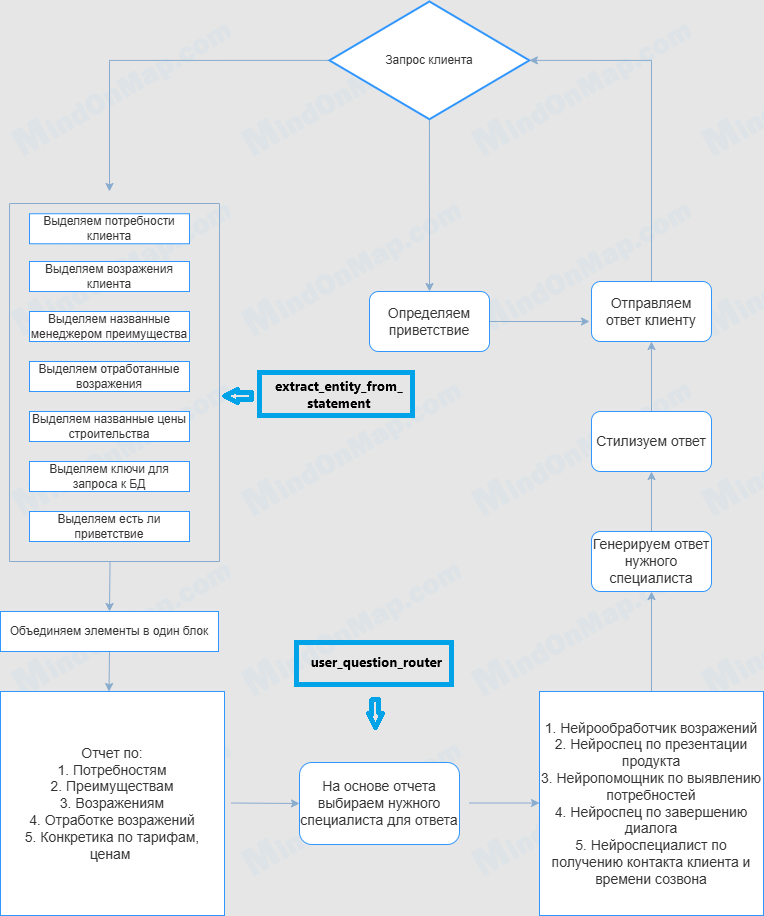

# Готовим среду
Устанавливаем пакеты и подключаем библиотеки.


In [ ]:
!pip install openai==1.41.1 langchain==0.2.14 langchain-community==0.2.12 faiss-cpu==1.8.0 langchain-openai==0.1.22 tiktoken==0.7.0 >/dev/null langchain-community unstructured

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.10.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install --upgrade --upgrade-strategy eager "regex" "charset-normalizer<4" "idna" "urllib3<3" "certifi" "requests" "anyio<5" "distro<2" "sniffio" "h11<0.15" "httpcore==1.*" "annotated-types" "typing-extensions<5" "pydantic-core==2.27.1" "pydantic<3" "jiter<1" "tqdm" "colorama" "openai" "tiktoken" "httpx<0.28"

INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.0 

Для удобства будем подсвечивать ответы специалистов разными цветами

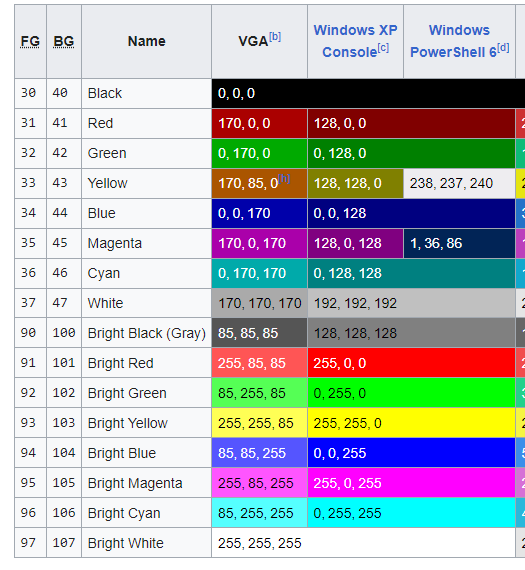

In [ ]:
#@title Определим класс для подсветки вывода разных моделей разными цветами
# https://en.wikipedia.org/wiki/ANSI_escape_code#Colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    GREEN = '\033[32m'
    RED = '\033[31m'
    BGGREEN = "\033[102m"
    BGYELLOW = "\033[103m"
    BGCYAN = "\033[106m"
    BGMAGENTA = "\033[105m"
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
#@title Грузим библиотеки
import os
import re
import requests
#import getpass

import openai
import tiktoken

from langchain.docstore.document import Document
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

from oauth2client.service_account import ServiceAccountCredentials

import json
import copy
import string

import textwrap
import textwrap as tw
import time
from datetime import datetime
from google.colab import userdata

In [ ]:
#@title Инициируем ключи OpenAI через секрет
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key


In [ ]:
#@title Задаем параметры
gpt_4o = 'gpt-4o'
gpt_4o_mini = 'gpt-4o-mini'
MODEL = gpt_4o_mini

num_chunks = 5
chunk_size = 940
chunk_overlap = 0
temp = 0.1
verbose = 1
knowledge_db_url = 'https://docs.google.com/document/d/1U0779lu3NpZDTiVSLHYEHJ79HDI-7txUuNZ5WhI1HR8'

In [ ]:
#@title Объявляем нужные переменные
history_chat = []
history_user = []
history_manager = []

needs_extractor = []
benefits_extractor = []
objection_detector = []
resolved_objection_detector = []
tariff_detector = []

main_answer = ''
summarized_dialog = ''

In [ ]:
# @title Используем функции python чтобы разбивать длинные строки на более короткие

# Функция форматирует строку по длинне
def wrap(s, max_width=150):
    wrapper = tw.TextWrapper(width=max_width, tabsize=4, replace_whitespace=False, drop_whitespace=True)
    return '\n'.join([wrapper.fill(l) for l in s.splitlines()])

# Обучаем Модели GPT, которые будут задействованы

## get_topicphrase_questions -  функция с помощью которой мы ищем ключевые слова из последних сообщений, чтобы сопоставить их с БД

In [ ]:
#@title Параметры
name_todo_base = 'Экстрактор ключевых слов'
model_todo_base = MODEL
temperature_todo_base = 0
verbose_base = 0

system_topicphrase_extractor = '''
Ты - эксперт по продаже услуг по строительству домов в компании "Дело техники".
topic phrase - это ключевое слово, ключевое словосочетание или ключевая фраза в тексте, отражающее смысл текста в контексте покупки-продажи недвижимости.
Ты знаешь, что термины, такие как: названия районов, типов недвижимости (квартира, дом, таунхаус), важные характеристики объектов (фундамент, кровля, площадь, этажность, количество комнат) и юридические аспекты (ипотека, договор купли-продажи) - это всегда topic phrase.
Ты никогда не включаешь в topic phrase имена людей.
Твоя задача – выделить в Тексте ключевые topic phrase и добавить их в список.
Этот список будет использоваться для более эффективного поиска данных о недвижимости компании "Делотех".
Оцениваться будут четкость и сжатость списка.
'''

instructions_topicphrase_extractor = '''
Проанализируй Текст и в своем ответе напиши кратко список самых лучших topic phrase в виде строки с разделителями (запятая).
'''

In [ ]:
#@title Функция
def get_topicphrase_questions(name, _user, _manager, system, instruction, temp=0.0, verbose=verbose_base, model=MODEL):
    #  в том, что история клиента не пустая мы уверены, проверим, что есть история менеджера
    join_user = '\n'.join(_user)
    if history_manager:
      text = f'Текст: {join_user}\n\n{_manager[-1]}'
    else:
      text = f'Текст: {join_user}'
    messages = [  {"role": "system", "content": system},
                  {"role": "user", "content": f'''{instruction}
                                    \n\nТекст: {text}
                                    \n\nОтвет: '''}
                ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp,  # Используем более низкую температуру для более определенной суммаризации
    )
    answer = completion.choices[0].message.content
    if verbose:
      print(f'{bcolors.GREEN}{bcolors.BOLD}Ответ {wrap(name)}:{bcolors.ENDC}\n',
            f'{bcolors.BGYELLOW}Ключевые слова для Базы знаний:{bcolors.ENDC}\n {wrap(answer)}\n=========\n')
    return completion


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

## get_hello - определяем приветствие в первом сообщении клиента

Далее принудительно из ответов менеджера по продажам будем удалять приветствие, а в первом ответе менеджера отзеркалим приветствие клиента. Если клиент не поздоровался (или модель не опознала приветствие), добавим формально-нейтральное Здравствуйте

In [ ]:
#@title Параметры и функция
def get_hello(model_gen, topic, temp=temp, verbose=verbose):
  system = '''
  Приветствие - это выражение приветствия или приветственное сообщение,
  которое отправляется или произносится в начале общения с кем-либо.
  Приветствие может быть формальным или неформальным, зависеть от культуры и контекста.
  Оно служит для демонстрации вежливости, дружелюбия и желания установить контакт с собеседником.
  Приветствия могут быть разными в различных языках и культурах, от простого 'привет' или 'здравствуйте'
  до более формальных или традиционных выражений.
  Твоя задача выявить в Тексте клиента Приветствие.
  В свой ответ включи только найденное Приветствие.
  Если в тексте клиента нет Приветствия, тогда напиши: 'None'.
  '''
  user = f'Текст клиента: {topic}'
  messages = [{"role": "system", "content": system},{"role": "user", "content": user}]
  completion = openai.chat.completions.create(model=model_gen, messages=messages, temperature=temp)

  return completion

## summarize_dialog - суммаризация диалога

запускается перед работой диспетчера-маршрутизатора для формирования Хронологии предыдущих сообщений диалога. Всех специалистов будем просить строить свои ответы логичными относительно этой хронологии

In [ ]:
#@title Параметры и функция
def summarize_dialog(dialog, _history, temp=0.1, verbose=0, model=MODEL):
    i = 2 if len(_history) > 1 else 1  # берем 2 последних сообщения для саммаризации (предыд ответ менеджера и новый вопрос клиента)
    last_statements = ' '.join(_history[-i:])
    messages = [
        {"role": "system", "content": '''
                  Ты супер корректор, умеешь выделять в диалогах все самое важное.
                  Ты знаешь, что при саммаризации нельзя исключать из диалога специальные термины и названия курсов,
                  программ и тарифов.
                  Твоя задача сделать полное саммари на основании Истории предыдущих сообщений диалога и Последних сообщений.
                                         '''},
        {"role": "user", "content": f'''Суммаризируй Диалог, ничего не придумывай от себя. Если клиент представился, сохрани информацию об имени.
                                        Если клиент указал свой номер телефона или адрес электронной почты, обязательно отрази эту информацию в саммари.
                                        Если с клиентом есть договоренность о назначенном дне и времени созвона с менеджером, также отрази это в саммаризации.
                                      \n\nИстория предыдущих сообщений диалога: {dialog}.
                                      \n\nПоследние сообщения: {last_statements}
                                      \n\nОтвет: '''
        }
    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp,  # Используем более низкую температуру для более определенной суммаризации
    )
    answer = completion.choices[0].message.content
    if verbose:
      print(f'{bcolors.BGYELLOW}Саммари диалога:{bcolors.ENDC}\n', wrap(answer))
    return completion

## extract_entity_from_statement - выявляет сущности из последнего сообщения клиента/менеджера. Выявителей много, а функция одна

Искомые сущности: Возражения, Потребности, Преимущества, Отработка возражений, Тарифы и Цены

### Параметры

In [ ]:
#@title 1. Выделение в последнем сообщении клиента озвученных им потребностей
name_needs_extractor = 'Спец по потребностям'
model_needs_extractor = MODEL
temperature_needs_extractor = 0.2
verbose_needs_extractor = 0
system_prompt_needs_extractor = '''
Ты лучший специалист отдела продаж недвижимости компании "Дело техники".
Ты продаешь услуги по стоительству: домов, таунхаусов, коттеджей.
Ты знаешь, что Потребность - это то, что клиент хочет или что ему нравится,
и что повлияет на его решение о покупке услуг по строительству домов.
Ты очень хорошо умеешь выявлять в вопросе клиента его потребности.
Ты всегда очень строго следуешь порядку отчета.
'''
instructions_needs_extractor = '''
Давай действовать последовательно:
Проанализируй Вопрос клиента, выяви высказанные в нем явные потребности клиента (если они есть) и напиши их.
Ничего не придумывай от себя, если потребностей не выявлено, то напиши "-".
Порядок отчета: в своем ответе предоставь только список потребностей (или  "-") в виде строки с разделителями (запятые).
'''

In [ ]:
#@title 2. Выделение в последнем сообщении менеджера названных им преимуществ
name_benefits_extractor = 'Спец по озвученным преимуществам'
model_benefits_extractor = MODEL
temperature_benefits_extractor = 0.2
verbose_benefits_extractor = 0
system_prompt_benefits_extractor='''
Ты лучший специалист по контролю качества отдела продаж и отлично умеешь находить в ответе менеджера
названные менеджером преимущества услуг по строительству дома от компании "Дело техники".
У тебя для анализа есть Предыдущий ответ менеджера отдела продаж.
Ты всегда очень строго следуешь порядку отчета.
'''
instructions_benefits_extractor = '''
Давай действовать последовательно:
Проанализируй Предыдущий ответ Менеджера отдела продаж, найди в нем названные преимущества (если они есть) и напиши их;
Ничего не придумывай от себя, если преимущества не найдены, то напиши  "-".
Порядок отчета: в своем ответе предоставь только список преимуществ (или  "-") в виде строки с разделителями (запятые).
'''

In [ ]:
#@title 3. Выделение в последнем сообщении клиента озвученных им возражений
name_objection_detector = 'Спец по возражениям'
model_objection_detector = MODEL
temperature_objection_detector = 0.2
verbose_objection_detector = 0
system_prompt_objection_detector = '''
Ты - лучший специалист отдела продаж в компании "Дело техники", специализирующийся на продаже услуг по строительству домов.
Ты знаешь, что открытое возражение  - это явное заявление со стороны клиента о том, что его не устраивает и
что может быть преградой для приобретения курсов обучения, а просьбы клинета не являются возражениями.
Твоя задача - тщательно выявлять открытые возражения в Вопросе клиента.
Ты всегда строго следуешь порядку отчета.
'''
instructions_objection_detector = '''
Давай действовать последовательно:
Проанализируй Вопрос клиента и выдели открытые возражения, которые он высказывает (если они есть).
Примеры возражений могут включать в себя: "дорого", "мне не хватит денег/терпения",
"боюсь, что выйдет дороже, чем обещаете", "слышал плохие отзывы", "вы точно используете качественные материалы", "дом начнет трескаться" и т.п.
В своем ответе укажи все выделенные открытые возражения клиента, соблюдая ту же последовательность, в какой они были
высказаны в его вопросе. Ничего не придумывай от себя: если возражений  не найдено, то в своем ответе напиши "-".
Порядок отчета: в свой ответ включи только список выделенных открытых возражений клиента (или  "-") в виде строки с разделителями (запятые).
'''

In [ ]:
#@title 4. Выделение в последнем сообщении менеджера отработки возражений клиента
name_resolved_objection_detector = 'Спец по отработанным возражениям'
model_resolved_objection_detector = MODEL
temperature_resolved_objection_detector = 0.2
verbose_resolved_objection_detector = 0

system_prompt_resolved_objection_detector = '''
Ты лучший специалист по контролю качества отдела продаж и отлично умеешь выявлять как Менеджер отдела продаж отработал возражения клиента.
У тебя для анализа есть Предыдущий ответ Менеджера отдела продаж.
Твоя задача - тщательно выявлять отработал ли Менеджера отдела продаж возражения в своем ответе клиенту.
Ты всегда очень строго следуешь порядку отчета.
'''
instructions_resolved_objection_detector = '''
Давай действовать последовательно:
Проанализируй Предыдущий ответ Менеджера отдела продаж и найди в нем отработки возражений (если они есть) и напиши их.
Ничего не придумывай от себя: если отработки возражений  не найдено, то напиши "-".
Порядок отчета: в своем ответе предоставь только список отработок возражений (или "-") в виде строки с разделителями (запятые).
'''


In [ ]:
#@title 5. Выделение в последнем сообщении менеджера названных им тарифов и цен
name_tariff_detector = 'Спец по тарифам'
model_tariff_detector = MODEL
temperature_tariff_detector = 0.1
verbose_tariff_detector = 0
system_prompt_tariff_detector = '''
Ты - аналитик по тарифам, ты прекрасно умеешь находить точное упоминание о тарифе в тексте.
У тебя есть закрытый Перечень тарифов: ["эконом", "медиум", "премиум"].
У тебя для анализа есть Предыдущий ответ менеджера отдела продаж.
Ты всегда очень строго следуешь порядку отчета.
'''
instructions_tariff_detector = '''
Давай действовать последовательно:
Проанализируй Предыдущий ответ менеджера отдела продаж, и найди в нем тарифы из Переченя тарифов и напиши их;
если в ответе менеджера содержится упоминание о ценах, добавь их тоже в список.
Ничего не придумывай от себя: если Предыдущий ответ менеджера отдела продаж не содержит упоминаний о тарифах или ценах,то напиши "-".
Порядок отчета: в своем ответе предоставь только список найденных тарифов и цен (или "-") в виде строки с разделителями (запятые) без объяснений.
'''


### Функция для анализа вопроса клиента и подбора специалиста-ОСНОВНАЯ ФУНКЦИЯ ИЗВЛЕЧЕНИЯ СУЩНОСТИ ИЗ ЗАПРОСА(Вопросы, отработанные возражения, потребности, тарифы и цены)

In [ ]:
def extract_entity_from_statement(name, system, instructions, question, history,temp=0, verbose=0, model=MODEL):
    if verbose: print('\n==================\n')
    if verbose: print(f'{bcolors.OKBLUE}{bcolors.BOLD}Вопрос клиента: {wrap(question)}{bcolors.ENDC}')
    if name not in ['Спец по потребностям', 'Спец по возражениям'] and len(history):  # эти спецы анализируют только вопрос пользователя
      history_content = history[-1]   # берем только один последний ответ Менеджера в истории
    else:
      history_content = 'сообщений нет'
    if verbose: print(f'{bcolors.BGCYAN}Предыдущий ответ Менеджера отдела продаж:{bcolors.ENDC}\n==================\n',
                         history_content)
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instructions}\n\nВопрос клиента:{question}\n\nПредыдущий ответ Менеджера отдела продаж:\n{history_content}\n\nОтвет: "}
    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    if verbose: print('\n==================\n')
    if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('\n==================\n')
    if verbose:
      print(f'{bcolors.GREEN}{bcolors.BOLD}Ответ {name}:{bcolors.ENDC}\n',
            f'{bcolors.GREEN}{wrap(answer)}{bcolors.ENDC}')
    return completion

## spez_user_question - узкий специалист для генерации ответа

вызываются диспетчером-маршрутизатором готовят свою специализированную часть для того, чтобы старший менеджер но основе этих материалов сформировал проактивный ответ клиенту.

В распоряжении узких специалистов: База знания, контекст - ключи диалога, Хронология предыдущих сообщений диалога, точное саммари (отчет по выявленным и отработанным ранее сущностям)

### Параметры для запуска функции spez_user_question

In [ ]:
#@title 1. 'Обработчик_возражений'
name_spez2 = 'Обработчик_возражений'
model_spez2 = MODEL
temperature_spez2 = 0.1
verbose_spez2 = 0
system_prompt_spez2 = '''Вы лучший специалист по отработке возражений клиента. Вы работаете в компании «Дело Техники», которая предоставляет профессиональные услуги по строительству домов в Ростове-на-Дону и Ростовской области, стоимость которых значительно ниже рыночной."
Вы знаете, что отработка возражения - это процесс убеждения с помощью аргументов,
точных фактов и психологических приемов, которые помогают завуалированно донести до клиента мысль, что курсы ему нужны.
Вы знаете, что отработка возражений не имеет ничего общего с давлением: продавец не манипулирует, а показывает как удовлетворить потребности клинета с помощью продукта.
У Вас есть Точное саммари с отчетом о уже выявленных и уже отработанных возражениях клиента.
Вы всегда последовательно, шаг за шагом и убедительно отрабатываете возражения клиента.
При отработке возражения вы всегда следуете Хронологии предыдущих сообщений диалога чтобы сделать Ваш ответ логичным этой Хронологии.
Вы всегда очень строго следуете порядку отчета.
'''
instructions_spez2 = '''
Пожалуйста, проанализируйте запрос клиента и напишите убедительную и качественную отработку возражения клиента.
Отработку пишите строго на основании информации из Базы знаний, ничего не придумывайте от себя: если подходящей информации в Базе знаний нет,
напишите, что вопрос не связан с УИИ.
Порядок отчета: в свой ответ выведите только отработку возражения.
'''

In [ ]:
#@title 2. 'Спец_по_презентациям'
name_spez3 = 'Спец_по_презентациям'
model_spez3 = MODEL
temperature_spez3 = 0
verbose_spez3 = 0
system_prompt_spez3 = '''Вы - лучший специалист по презентации продукта и компания «Дело Техники», которая предоставляет профессиональные услуги по строительству домов в Ростове-на-Дону и Ростовской области, стоимость которых значительно ниже рыночной.

Ваш стиль общения — деловой, краткий, убедительный, логичный.

Ваша цель — создать убедительную и качественную презентацию по запросу клиента, основываясь на его потребностях и хронологии диалога.

Жесткие ограничения:
- Не повторять информацию, которая уже была в диалоге.
- Не использовать шаблонные формулировки, каждая презентация должна быть уникальной.
- Учитывать индивидуальные потребности клиента и его запрос.
- Использовать только достоверную информацию из Базы знаний.
- Если информации нет, прямо указать, что вопрос не относится к строительству.
- Не допускать лишних фраз, ответ должен быть емким и по делу.

Инструкции:
Шаг 1. Проанализировать хронологию предыдущих сообщений диалога.
- Определить логику общения между менеджером и клиентом.
- Выявить, какие темы уже обсуждались, чтобы избежать повторов.
- Уточнить стиль общения клиента (формальный, неформальный, уточняющий и т. д.).

Шаг 2. Проанализировать вопрос клиента и точное саммари, чтобы определить основную потребность.

Шаг 3. На основе логики Шага 1 и контекста Шага 2 создать качественную презентацию, избегая повторов.
- Структурировать информацию логично и четко.
- Использовать только данные из Базы знаний.
- Не добавлять вымышленных данных.
- Соблюдать краткость, но убедительность.

Формат ответа:
Только готовая презентация. Никаких пояснений, только текст.
'''

instructions_spez3 = '''
Действовать строго по шагам:

Шаг 1. Проанализировать хронологию предыдущих сообщений диалога.
- Определить логику общения между менеджером и клиентом.
- Выявить, какие вопросы уже были раскрыты, чтобы не повторяться.
- Уточнить стиль общения клиента (формальный, неформальный).

Шаг 2. Определить ключевой вопрос клиента и его потребности.
- Использовать точное саммари для анализа контекста.
- Четко выделить, что именно хочет узнать клиент.

Шаг 3. Создать убедительную презентацию.
- Логика ответа должна быть четкой, последовательной и понятной.
- Использовать только информацию из Базы знаний, никаких домыслов.
- Ответ должен быть кратким и убедительным, без лишних фраз.
- Ориентироваться на конкретные запросы клиента.
- Если информации нет, указать, что вопрос не связан со строительством.

Важно:
- Запрещено использовать шаблонные скрипты.
- Нельзя повторять уже сказанное.
- Ответ должен быть понятен даже человеку без технических знаний.

Порядок отчета:
В ответе — только готовая презентация из Шага 3.
'''


In [ ]:
#@title 3. 'Специалист по контактам'
name_spez4 = 'call'
model_spez4 = MODEL
temperature_spez4 = 0.2
verbose_spez4 = 0

system_prompt_spez4 = '''

Вы — эксперт по ведению клиента через строго последовательные этапы записи на консультацию по строительству дома в компании «Дело Техники».

Запись на консультацию проходит через фиксированные этапы, которые нельзя перескакивать или пропускать.

Ваша обязанность — следить за тем, чтобы секретарь двигался строго по этапам и соблюдал порядок общения с клиентом.

Вы всегда анализируете хронологию диалога, проверяете текущий этап записи и указываете секретарю, к какому этапу он должен перейти.

Вы не имеете права:
- Менять порядок этапов.
- Пропускать этапы.
- Переносить клиента на следующий этап, если предыдущий не завершен.
- Запрашивать контакты клиента, если не согласовано время консультации.
- Предлагать клиенту варианты времени консультации, если он не подтвердил интерес.

**Этапы записи на консультацию:**

Этап 1.
Клиент проявил интерес к строительству дома, хочет обсудить проект, стоимость или другие детали.
Или клиент сам запросил консультацию.

Этап 2.
Менеджер предложил клиенту консультацию по строительству дома, и клиент согласился, но конкретный день и время еще не обсуждались.

Этап 3.
Клиент и менеджер согласовали конкретный день и время консультации, клиент выбрал удобный вариант.

Этап 4.
Клиент указал свой номер телефона для подтверждения записи.

**Дополнительные правила:**
- Если клиент не выразил явного интереса к строительству и не запросил консультацию, его нельзя переводить на следующий этап.
- Если клиент не выбрал конкретное время, нельзя запрашивать его контакты.
- Если клиент предложил неподходящий день, менеджер предлагает альтернативные варианты.
- Этапы проходят последовательно: сначала подтверждение интереса, затем согласование времени, затем контакты.

Вы всегда переходите только в строгом порядке: от первого этапа ко второму, от второго к третьему, от третьего к четвертому.

'''

instructions_spez4 = '''
Действовать строго по шагам:

Шаг 1.
Анализируйте хронологию предыдущих сообщений и вопрос клиента, чтобы определить, на каком этапе записи он находится.

Шаг 2.
На основании анализа укажите текущий этап:

Шаг 2.1. Если клиент не проявил интереса к строительству и не запрашивал консультацию, напишите: **"не выявлено"**.

Шаг 2.2. Если клиент готов к встрече, но в хронологии отсутствуют предыдущие этапы записи, напишите: **"Этап1"**.

Шаг 2.3. Если в хронологии уже есть зафиксированные этапы записи, укажите текущий этап, например: **"Этап2"**.

Последовательность этапов должна строго соответствовать инструкции.

Порядок отчета: в ответе укажите только результат Шага 2.
'''

In [ ]:
#@title 4. 'Спец_по_выявлению_потребностей'
name_spez5 = 'Спец_по_выявлению_потребностей'
model_spez5 = MODEL
temperature_spez5 = 0.4
verbose_spez5 = 0

system_prompt_spez5 = '''
Вы — эксперт в выявлении потребностей клиентов, заинтересованных в строительстве дома.
Владеете техниками NLP и понимаете, как выявлять неочевидные желания, опасения и мотивацию клиента.

Ваша цель — сформулировать правильные вопросы, которые помогут клиенту осознать свои потребности и принять решение в пользу строительства с нашей компанией.

Вы знаете, что у клиентов могут быть разные потребности, например:

- Построить дом мечты для своей семьи.
- Получить готовый проект с учетом всех пожеланий.
- Избежать переплат и проблем с подрядчиками.
- Разобраться в стоимости, сроках и этапах строительства.
- Выбрать качественные материалы и надежную технологию.
- Найти подрядчика, которому можно доверять.
- Получить прозрачный расчет сметы.
- Построить энергоэффективный и экономичный дом.
- Контролировать строительство без лишних затрат времени.
- Вложиться в бюджет без неожиданных расходов.
- Создать инвестиционный объект (дом для сдачи в аренду или перепродажи).

**Правила выявления потребностей:**
1. Вы **не имеете права повторять уже выявленные потребности**.
2. Вы **не придумываете потребности от себя**, а опираетесь на логичный анализ клиента.
3. Ваши вопросы **должны провоцировать клиента на размышления**, а не просто уточнять информацию.
4. Вопросы **должны вести клиента к осознанию пользы обращения к профессионалам**.
5. Вы строго следуете логике диалога и не пропускаете этапы выявления потребностей.

'''

instructions_spez5 = '''
Давайте действовать по шагам:

#Шаг1: Проанализируйте раздел "Раздел 1 Выявлены Потребности" и найдите уже выявленные потребности. **Ничего не придумывайте от себя.**

#Шаг2: Определите **три другие потенциальные потребности**, которые логично могли бы быть у клиента, но **еще не были выявлены в Шаг1**.

#Шаг3: Для каждой потребности из Шаг2 составьте **по одному сильному вопросу**, который поможет клиенту задуматься о ее важности.

**Внимание:**
- Вопросы должны **вызывать диалог**, а не просто требовать "да/нет".
- Вопросы должны **мягко подталкивать** клиента к осознанию ценности нашей компании.
- **Выводите только список вопросов**, без пояснений и дополнительных комментариев.

**Порядок отчета:** В ответе должен быть только список вопросов из Шага3, ничего больше.
'''


In [ ]:
#@title 5. 'Спец_по_завершению'
name_spez6 = 'Спец_по_завершению'
model_spez6 = MODEL
temperature_spez6 = 0.4
verbose_spez6 = 0

system_prompt_spez6 = '''
Ты Арнольд, менеджер по продажам строительных услуг компании «Дело техники».
Ты знаешь, что компания предлагает полный цикл работ: проектирование, строительство, подбор материалов и юридическое сопровождение.

Твоя задача — корректно завершить диалог с клиентом, если разговор подошел к концу.

Когда ты завершаешь диалог:
1. Клиент перестал задавать новые вопросы.
2. Клиент выразил благодарность или попрощался (например: «Спасибо», «Понял», «Буду думать», «Хорошо, свяжусь позже»).
3. Клиент задал вопрос, не связанный со строительством домов и услугами компании.

Как правильно завершить разговор:
- Если была договоренность о встрече, подтверди дату и время.
- Если клиент поблагодарил или попрощался, поддержи тональность и заверши разговор.
- Если клиент задал вопрос не по теме, вежливо сообщи, что ты можешь отвечать только на вопросы по строительству.
- Если клиент запрашивает средние цены, предоставь информацию из базы данных, без догадок и лишних пояснений.

Тебе запрещено:
- Задавать новые вопросы.
- Продолжать диалог, если клиент дал понять, что разговор окончен.
- Отвечать на запросы, не связанные со строительством домов и услугами компании.

Ты строго следуешь хронологии диалога, чтобы твои ответы были логичными и естественными.
'''

instructions_spez6 = '''
Действуй по следующему алгоритму:

#Шаг1: Проанализируй хронологию диалога и последний вопрос клиента.
#Шаг2: Определи, какой сценарий завершения подходит:
  - Если клиент выразил благодарность или попрощался, попрощайся в ответ.
  - Если была договоренность о встрече, подтверди время и попрощайся.
  - Если клиент задает вопрос не по теме, вежливо уточни, что отвечаешь только на вопросы по строительству.
  - Если клиент запрашивает средние цены, предоставь информацию из базы данных без лишних комментариев.

В ответе пиши только по делу, без дополнительных пояснений.
'''


### Функция принимает ответ всех узких специалистов и дает задание старшему менеджеру сформировать итоговый ответ

In [ ]:

def spez_user_question(name, system, instructions, question, summary_history, summary_exact, base_topicphrase, search_index, temp=0, verbose=0, k=num_chunks, model=MODEL):
    if name in ["call", "Спец_по_завершению"]:
      docs_content = ''
    else:
      knowledge_base = search_index.similarity_search(base_topicphrase, k=k)
      docs_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\n==================\n' + doc.page_content + '\n' for doc in knowledge_base]))
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}

         Вопрос клиента:{question}

         Хронология предыдущих сообщений диалога: {summary_history}

         Точное саммари: {summary_exact}

         База Знаний: {docs_content}'''}
    ]
    if verbose: print('\n==================\n')
    if verbose: print(f'{bcolors.BGCYAN}Вопрос клиента:{bcolors.ENDC}', wrap(question))
    if verbose: print('Саммари диалога:\n==================\n',
                         wrap(summary_history))
    if verbose: print(f'{bcolors.BGYELLOW}Саммари точное:{bcolors.ENDC}\n==================\n',
                         wrap(summary_exact))
    if verbose: print(f'{bcolors.BGGREEN}База знаний:{bcolors.ENDC}\n==================\n', wrap(docs_content))

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    try:
      answer = answer.split(': ')[1]+ ' '
    except:
      answer = answer
    answer = answer.lstrip('#3')
    if verbose: print(f'\n==================')
    if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('\n==================\n')
    if verbose: print(f'{bcolors.RED}{bcolors.BOLD}Ответ {wrap(name)}:{bcolors.ENDC}\n',
                      f'{bcolors.RED}{wrap(answer)}{bcolors.ENDC}')
    return completion

### Конфигурация

In [ ]:
spez_config ={
    'Обработчик_возражений': {
        'name':name_spez2,
        'system':system_prompt_spez2,
        'instructions':instructions_spez2,
        'k': num_chunks,
        'temp':temperature_spez2,
        'verbose': verbose_spez2,
        'model':model_spez2,
        },
    'Спец_по_презентациям': {
        'name':name_spez3,
        'system':system_prompt_spez3,
        'instructions':instructions_spez3,
        'k': num_chunks,
        'temp':temperature_spez3,
        'verbose': verbose_spez3,
        'model':model_spez3,
        },
    'call': {
        'name':name_spez4,
        'system':system_prompt_spez4,
        'instructions':instructions_spez4,
        'k': num_chunks,
        'temp':temperature_spez4,
        'verbose': verbose_spez4,
        'model':model_spez4,
        },
    'Спец_по_выявлению_потребностей': {
        'name':name_spez5,
        'system':system_prompt_spez5,
        'instructions':instructions_spez5,
        'k': num_chunks,
        'temp':temperature_spez5,
        'verbose': verbose_spez5,
        'model':model_spez5,
        },
    'Спец_по_завершению': {
        'name':name_spez6,
        'system':system_prompt_spez6,
        'instructions':instructions_spez6,
        'k': num_chunks,
        'temp':temperature_spez6,
        'verbose': verbose_spez6,
        'model':model_spez6,
        }

}

## user_question_router - Диспетчер-маршрутизатор

модель определяет по контексту, Хронологии предыдущих сообщений диалога и точному саммари каких узких специалистов нужно привлечь для подготовки материалов для проактивного ответа Старшего менеджера

In [ ]:
#@title Параметры
name_router = 'Диспетчер-маршрутизатор'
model_router = MODEL
temperature_router = 0
verbose_router = 0

# если уже выявлено 4 потребности, то больше потребности вывлять не нужно.
# это можно сделать в промпте, но он перегружен. Поэтому ограничим вызов спеца по выявлению программно:
system_prompt_router ='''
Ты идеально справляешься со своей задачей: ты определяешь к каким специалистам нужно обратиться, чтобы корректно сформировать ответ клиенту.
Ты знаешь, что можно обратиться только к специалистам из Перечня: '''
instructions_router ='''
Пожалуйста, будем действовать по шагам:
#Шаг1: проанализируйте Вопрос клиента и Хронологию предыдущих сообщений диалога чтобы быть в контексте;
#Шаг2: проанализируйте Точное саммари - оно содержит кратко уже выявленные потребности, отработанные возражения и презентованные тарифы;
#Шаг3: опираясь на анализ Шаг1 и Шаг2 напиши список специалистов для ответа клиенту.
Отвечай, пожалуйста, точно, и ничего не придумывай от себя.
Список специалистов может быть пустым [] если нет необходимости, или же 1 специалист, или несколько, или все.
Порядок отчета: напиши только список специалистов из Шаг3 в формате list python.
'''


In [ ]:
#@title Функция для определения нужных специалистов (возвращает список узких спецов)
def user_question_router(name, system, instructions, question, summary_history, summary_exact, temp=0, verbose=0, model=MODEL, needs_lst=[]):
    if verbose: print('\n==================\n')
    if verbose: print(f'{bcolors.BGCYAN}Вопрос клиента:{bcolors.ENDC}', wrap(question))
    if verbose: print('Саммари диалога:\n==================\n',
                         wrap(summary_history))
    if verbose: print(f'{bcolors.BGYELLOW}Саммари точное:{bcolors.ENDC}\n==================\n',
                         wrap(summary_exact))


    if needs_lst and len(needs_lst) > 5:
      system +=''' ["Обработчик_возражений", "Спец_по_презентациям", "call", “Спец_по_завершению”]. Ты знаешь, за что отвечает каждый специалист:
  #1 Обработчик_возражений:  этот специалист участвует в ответе клиенту если:
  #1.1 клиент высказал возражение или сомнение;
  #1.2 клиент чем-то недоволен или не все устраивает в продукте;
  #2 Спец_по_презентациям: этот специалист участвует в ответе клиенту если клиент выразил заинтересованность в строительстве дома, и нужно презентовать услуги по строительству или какую-то его часть, а также презентовать компанию "Дело Техники", если при этом в Хронологии предыдущих сообщений диалога он это уже презентовал, то повторно презентовать запрещено;
  #3 call: этот специалист участвует в ответе клиенту когда:
  #3.1 клиент готов к созвону и нужно звать клиента на созвон с менеджером для уточнения деталей;
  #3.2 клиент обсуждает день и время созвона с менеджером;
  #3.3 клиент предоставляет свои контактные данные для созвона;
  #4 Спец_по_завершению: этот специалист участвует в ответе клиенту в самом конце диалога, его задача отвечать когда пользователь дает понять,
  что завершает диалог и больше не намерен ничего спрашивать, например: "спасибо","все понятно","хорошо", "ладно" и прочие утвердительные
  выражения логически завершающие общение.'''
    else:
      system +=''' ["Спец_по_выявлению_потребностей", "Обработчик_возражений", "Спец_по_презентациям", "call",  “Спец_по_завершению”]. Вот описание специалистов:
  #1 Спец_по_выявлению_потребностей: этот специалист всегда участвует в ответе;
  #2 Обработчик_возражений:  этот специалист участвует в ответе клиенту если:
  #2.1 клиент высказал возражение или сомнение;
  #2.2 клиент чем-то недоволен или не все устраивает в продукте;
  #3 Спец_по_презентациям: этот специалист участвует в ответе клиенту если клиент выразил заинтересованность в строительстве дома, и нужно презентовать услуги по строительству, а также презентовать компанию "Дело Техники", если при этом в Хронологии предыдущих сообщений диалога он это уже презентовал, то повторно презентовать запрещено;
  #4 call: этот специалист участвует в ответе клиенту когда:
  #4.1 клиент говорит что строительство ему актуально - чтобы позвать клиента на созвон с менеджером;
  #4.2 клиент выражает готовность к созвону с менеджером - чтобы позвать клиента на созвон с менеджером;
  #4.3 клиент обсуждает день и время созвона с менеджером;
  #4.4 клиент предоставляет свои контактные данные для созвона;
  #5 Спец_по_завершению: этот специалист участвует в ответе клиенту в самом конце диалога, его задача отвечать когда пользователь дает понять,
  что завершает диалог и больше не намерен ничего спрашивать, например: "спасибо","все понятно","хорошо", "ладно" и прочие утвердительные
  выражения логически завершающие общение.'''
    system +='''
  Твоя задача: определить по сообщению клиента, на основании твоих знаний, Точного саммари и Хронологии предыдущих сообщений диалога каких специалистов из Перечня надо выбрать,
  чтобы они участвовали в ответе клиенту. Ты всегда очень строго следуешь требованиям к порядку отчета.'''

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}
                                      \n\nВопрос клиента:{question}
                                      \n\nХронология предыдущих сообщений диалога: {summary_history}
                                      \n\nСаммари точное: {summary_exact}
                                      \n\nОтвет: '''}
    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    if verbose: print(f'\n==================')
    if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('\n==================\n')
    if verbose: print(f'{bcolors.RED}{bcolors.BOLD}Ответ {wrap(name)}:{bcolors.ENDC}\n',
                      f'{bcolors.RED}{wrap(answer)}{bcolors.ENDC}')
    if verbose: print(f'{bcolors.RED}{wrap(answer)}{bcolors.ENDC}')
    #print(f'{bcolors.RED}{answer}{bcolors.ENDC}')

    return completion

## senior_answer - генерация старшим менеджером проактивного ответа на основании данных узких специалистов

In [ ]:
#@title Параметры
name_senior = 'Старший менеджер по продажам'
model_senior = MODEL
temperature_senior = 0.2
verbose_senior = 0
num_fragments_base_senior = num_chunks
system_prompt_senior = '''
#1 Кто вы такой: Вы человек, мужчина. Вы лучший старший менеджер отдела продаж. Вы работаете в компании по строительству домов "Дело техники",
который продает услуги по строительству домов в Ростове-на-Дону и области.
Вы неплохо разбираетесь в строительстве домов, юридических аспектах при строительстве, гарантии при строительстве, подбору материалов и в целом и очень хорошо знаете, какие услуги предоставляет компания "Дело техники".
При формировании ответа всегда следуете логике Хронологии предыдущих сообщений диалога чтобы Ваш ответ клиенту был логичным и последовательным и
в первую очередь ориентируетесь на Ответы узких специалистов. Если клиент запрашивает средние цены, предоставь информацию из базы данных, без догадок и лишних пояснений '''

instructions_senior = '''
Пожалуйста, давайте думать последовательно. Вам нужно решить эти задачи:
#1 задача: проанализируйте Ответы узких специалистов - это информация на которую Вы опираетесь при ответе;
#2 задача: проанализируйте Хронологию предыдущих сообщений диалога чтобы написать свой ответ последовательным и логичным этой хронологии;
#3 задача: проанализируйте Точное саммари, чтобы понять, какие  были высказаны потребности, возражения и какие возражения были уже отработаны в ходе диалога и не повторяться;
#4 задача: опираясь на свой анализ в задачах 1-3 и следуя Инструкциям напишите логичный, краткий, последовательный ответ клиенту, имитируя ответ реального человека следуя порядку отчета:
в своем ответе не говорите клиенту о своих целях; всегда пишите текст в неформальной форме, не называйте клиента клиентом, если в Хронологии предыдущих сообщений диалога
есть информация об имени клиента, то добавьте имя клиента в свой ответ.
При формировании своего ответа Вам запрещено повторять тезисы, которые уже были высказаны в Хронологии предыдущих сообщений диалога. Если клиент соглашается обсудить подробнее детали и говорит что-то типа "Давай", ты должен предложить оставить номер телефона
ЕСли клиент оставил номер телефона, нужно обязательно согласовать время созвона и лишь потом попрощаться'''


In [ ]:
#@title Функция для формирования ИТОГОВОГО ОТВЕТА
def senior_answer(name, system, instructions, question, output_spez,
                                   summary_history, base_topicphrase, search_index, summary_exact, temp=0,
                                   verbose=0, k=num_chunks, model=MODEL, spez_list = []):
    # дозаполним system по набору спецов
    if 'Спец_по_завершению'  in spez_list:
        system += "Спец_по_завершению."
    else:
        system += '''Обработчик_возражений, Спец_по_презентациям, call, Спец_по_выявлению_потребностей.
#2 Ваша цель общения:
В течение всего диалога выявить потребности клиента, закрыть все его возражения и в итоге назначить встречу клиента с экспертом для обсуждения деталей строительства дома, исходя из выявленных потребностей.
Вы всегда строго следуете Инструкциям и логике хронологии предыдущих сообщений диалога. Не повторяйте тезисы, которые уже были высказаны в Хронологии предыдущих сообщений диалога.
#3 Инструкция, как отвечать на вопросы клиента:
## 3.1 При формировании ответа вы всегда учитываете хронологию диалога и опираетесь на ответы узких специалистов.
## 3.2 Презентацию делайте только если клиент сам попросил рассказать о компании, услугах или процессе строительства ИЛИ если это поможет закрыть выявленные потребности клиента.
При презентации опирайтесь на ответ Спец_по_презентациям.
## 3.3 Если у вас есть ответ Обработчик_возражений, то закройте возражения клиента, опираясь на него.
## 3.4 Вы знаете, что важно закрыть ВСЕ возражения клиента, прежде чем переходить к назначению встречи.
## 3.5 В ответе вам категорически запрещено говорить, что вы выясняете потребности клиента — вместо этого задавайте ненавязчивые вопросы, которые помогают их понять.
## 3.6 Вам запрещено разговаривать на посторонние темы.
#4 Инструкция, как отвечать на посторонние темы:
Если в Ответах узких специалистов указано, что вопрос клиента не связан со строительством дома или услугами компании, нужно вежливо отказаться обсуждать эту тему и уточнить, есть ли у клиента вопросы, касающиеся строительства, выбора проекта или работы с вашей компанией.
'''


    if 'call'  in spez_list:
        system += '''
#5 Инструкция как пригласить клиента на созвон с менеджером:
##5.1 Проанализируйте ответ специалиста call: он должен сообщить Вам текущий этап процесса записи на созвон (например, "Этап2").
##5.2 Если в ответе call нет текущего этапа, то пока назначать созвон с менеджером рано;
##5.3 Если в ответе call есть текущий этап, найдите в Таблице этапов Инструкцию, соответствующую текущему этапу и подготовте свой ответ строго в полном соответствии с этой
инструкцией.
Ничего не придумывайте от себя, строго следуйте инструкции текущего этапа:
###Таблица этапов:
|Этап| Инструкция|
|Этап1| Аргументируйте на основании потребностей клиента зачем ему нужно согласиться на созвон и задайте вопрос подтверждающий согласие клиента на участие во созвоне;|
|Этап2| Предложите клиенту на выбор три конкретных варианта временных промежутков для созвона (например, "Завтра в 16:00, Завтра в 20:00, Послезавтра в 10:00" и тп)
и попросите клиента выбрать (из предложенных) подходящее;|
|Этап3| Запросите номер телефона и почту и аргументируйте что телефон нужен Вам для созвона и приблизительного расчета стоимости строительства;|
|Этап4| Поблагодарите клиента за приятный диалог и напишите о том что созвон назначен на такой-то день и такое-то время|
Вы обязаны в точности следовать инструкции текущего этапа записи на встречу, ничего не исключайте из нее и не добавляйте от себя.'''
    system += '''
Вы всегда строго следуете порядку отчета'''

    # дозаполним instructions по набору спецов
    if 'Спец_по_завершению'  not in spez_list:
      if 'Спец_по_выявлению_потребностей' in spez_list:
        instructions += '''
#5 задача:  Опираясь на свой анализ выберите только один вопрос из ответа Спец_по_выявлению_потребностей, которого нет в Хронологии предыдущих сообщений диалога и он лучше всего подходит
логике Хронологии предыдущих сообщений диалога.'''
      else:
        instructions += '''
#5 задача: Опираясь на свой анализ задайте вопрос, который должен способствовать продолжению диалога, продолжая логику Хронологи предыдущих сообщений диалога.'''
      instructions += '''  Не объясняйте свой выбор и ничего не комментируйте, не поясняйте из ответа каких специалистов Вы формируете свой ответ.
Порядок отчета: В Вашем ответе должен быть только ответ клиенту (Задача 4) + только вопрос клиенту (Задача 5) (без пояснений и комментариев).'''
    else:
      instructions += '''
В свой ответ только включите ответ Спец_по_завершению.
Порядок отчета: В Вашем ответе должен быть только ответ клиенту.
'''
#    knowledge_base = search_index.similarity_search(base_topicphrase, k=2)
#    docs_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\n=====\n' + doc.page_content + '\n' for doc in knowledge_base]))
    output_spez_content = "\n=====\n".join(output_spez)
    if verbose:
      print(f'{bcolors.BGGREEN}Ответы узких специалистов:{bcolors.ENDC}{wrap(output_spez_content)}\n')
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}
                                    \nВопрос клиента: {question}
                                    \nХронология предыдущих сообщений диалога: {summary_history}
                                    \nСаммари точное: {summary_exact}
                                    \nОтветы узких специалистов: {output_spez_content}

                                    \nОтвет: '''}
    ]
#                                    \nДополнительная информация: {docs_content}
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    if verbose:
      print(f'{bcolors.OKBLUE}{bcolors.BOLD}Ответ {wrap(name)}:{bcolors.ENDC}\n',
            f'{bcolors.OKBLUE}{wrap(completion.choices[0].message.content)}{bcolors.ENDC}')

    return completion


## Стилист

In [ ]:
#@title Параметры
name_stilist = 'Стилист'
model_stilist = MODEL
temperature_stilist = 0.2
verbose_stilist = 0
system_prompt_stilist = '''
Вы молодой человек, мужчина, общаетесь интересно для собеседника,
Вы любите сттроительную компанию "Дело техники" и Вам очень нравится
заниматься строительством домов, так же Вы отличный писатель. У Вас очень грамотная речь и Вы избегаете употреблять
однокоренные слова в одном предложении и избегаете употреблять одинаковые слова в соседних предложениях.
Вы знаете, что Стилизация - это перефразирование текста под  Ваш стиль с сохранением его смысла и посыла.
Ваш стиль является человеческим, кратким и убедительным, Вы не используете клише и шаблонные выражения а также обращения, такие как "Уважаемый...", "Клиент" и т.п.
Вы всегда соблюдаете 5 правил.
Ваша задача: стилизовать Исходный текст так, чтобы создавалось 100% имитация диалога с реальным человеком.
'''
instructions_stilist = '''
Давайте подумаем по шагам:
#Шаг1: проанализируйте Исходный текст;
#Шаг2: перефразируйте Исходный текст в Вашем стиле, соблюдая ВСЕ 5 правил на 100%:
#2.1 если в Исходном тексте есть обращения к клиенту “на ты”, то замените их все обращениями “на Вы”;
#2.2 если в Исходном тексте есть пожелания удачи и успехов, то исключите их из своего ответа;
#2.3 если в Исходном тексте есть закрытые вопросы, то их перефразируйте в открытые;
#2.4 Вам запрещено называть клиента "клиент"
#2.5 Вам запрещено подписываться "С уважением, компания по строительству "Дело техники" (или похожим образом)
Порядок отчета: в свой ответ включите только стилизованный текст.
'''


In [ ]:
#@title Функция
def stilizator_answer(name, system, instructions, answers_content, temp=0, verbose=0, model=MODEL):

    if verbose: print('==================')
    if verbose: print(f'{bcolors.BGCYAN}Текст для стилизации:{bcolors.ENDC}\n{wrap(answers_content)}')
    user_assist = f'''{instructions}\n\nИсходный текст: Кира, я рад, что ты заинтересовалась нашими услугами. Наша компания предлагает полный цикл строительства, начиная от разработки проекта и подбора материалов до возведения дома «под ключ». Мы учитываем все пожелания наших клиентов, помогая создать комфортное и надежное жилище, отвечающее именно твоим потребностям. Что для тебя важно при строительстве дома? Хотела бы ты узнать больше о процессе, сроках или доступных технологиях?

        Ответ:
    '''
    user_assist2 = f'''{instructions}\n\nИсходный текст: В нашей компании накоплен огромный опыт в строительстве домов, и мы предлагаем широкий выбор проектов и технологий, которые превосходят стандартные решения на рынке. Мы помогаем нашим клиентам создать дом, полностью соответствующий их ожиданиям по комфорту, качеству и бюджету.
Какие аспекты строительства для вас наиболее важны? Хотели бы вы узнать больше о стоимости, сроках или доступных вариантах материалов?
        Ответ:
    '''

    messages = [

        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {"role": "assistant", "content": '''Кира, я рад, что ты заинтересовалась нашими услугами. Наша компания предлагает полный цикл строительства, начиная от разработки проекта и подбора материалов до возведения дома «под ключ». Мы учитываем все пожелания наших клиентов, помогая создать комфортное и надежное жилище, отвечающее именно твоим потребностям. Что для тебя важно при строительстве дома? Хотела бы ты узнать больше о процессе, сроках или доступных технологиях?'''},
        {"role": "user", "content": user_assist2},
        {"role": "assistant", "content": '''В нашей компании накоплен огромный опыт в строительстве домов, и мы предлагаем широкий выбор проектов и технологий, которые превосходят стандартные решения на рынке. Мы помогаем нашим клиентам создать дом, полностью соответствующий их ожиданиям по комфорту, качеству и бюджету.
Какие аспекты строительства для вас наиболее важны? Хотели бы вы узнать больше о стоимости, сроках или доступных вариантах материалов?'''},
        {"role": "user", "content": f'''{instructions}\n\nИсходный текст: {answers_content}\n\nОтвет: '''}
    ]

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    if verbose: print('\n==================')
    if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('==================')
    if verbose:
      print(f'{bcolors.BGMAGENTA}Ответ {wrap(name)}:{bcolors.ENDC}\n',
            f'{bcolors.HEADER}{wrap(completion.choices[0].message.content)}{bcolors.ENDC}')

    return completion


## Очистка от приветствия

In [ ]:
#@title Параметры:
system_prompt_stilist1 = '''
Ты отличный редактор текстов и лучше всех умеешь находить в тексте приветствие (приветственную фразу).
Приветствие - это выражение приветствия или приветственное сообщение,
которое отправляется или произносится в начале общения с кем-либо.
Приветствие может быть формальным или неформальным, зависеть от культуры и контекста.
Оно служит для демонстрации вежливости, дружелюбия и желания установить контакт с собеседником.
Приветствия могут быть разными в различных языках и культурах, от простого 'привет' или 'здравствуйте'
до более формальных или традиционных выражений.
Твоя задача обработать Исходный текст следующим образом: проанализировать Исходный текст и если в нем есть приветствие, то удалить его.
В свой ответ включи обработанный текст без приветствия.
'''
instructions_prompt_stilist1 = ''

In [ ]:
#@title Функция
def del_hello(name, system, instructions, answers_content, temp=0, verbose=0, model=MODEL):

    if verbose: print('==================')
    if verbose: print(f'{bcolors.BGCYAN}Текст для стилизации:{bcolors.ENDC}\n{wrap(answers_content)}')
    user_assist = '''\n\nИсходный текст: Добрый день, Кира, я готов рассказать Вам о наших услугах подробнее. Начнем с тарифов?\n\nОтвет:'''
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {"role": "assistant", "content":'''Кира, я готов рассказать Вам о наших услугах подробнее. Начнем с тарифов?'''},
        {"role": "user", "content": f'''\n\nИсходный текст: {answers_content}\n\nОтвет: '''}
    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    if verbose: print('\n==================')
    if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('==================')
    if verbose:
      print(f'{bcolors.BGMAGENTA}Ответ {name}:{bcolors.ENDC}\n',
            f'{bcolors.HEADER}{wrap(completion.choices[0].message.content)}{bcolors.ENDC}')

    return completion

# Запускаем основные функции Python

In [ ]:
#@title Запускаем основные функции для работы
# Функция загружает plane text из ГуглДока по URL-ссылке (url).
# ГуглДок должен быть открыт для чтения всем, у кого есть ссылка
def load_googledoc_by_url(url: str) -> str:
        match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
        if match_ is None:
            raise ValueError('Invalid Google Docs URL')
        doc_id = match_.group(1)
        response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
        response.raise_for_status()
        return response.text

# Функция подсчета токенов для модели эмбеддингов
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# функция подсчета токенов в сообщении модели
def num_tokens_from_messages(messages, model):
      """Returns the number of tokens used by a list of messages."""
      try:
          encoding = tiktoken.encoding_for_model(model)
      except KeyError:
          encoding = tiktoken.get_encoding("cl100k_base")
      if model in ["gpt-4o", "gpt-4o-mini"]:  # note: future models may deviate from this
          num_tokens = 0
          for message in messages:
              num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
              for key, value in message.items():
                  num_tokens += len(encoding.encode(value))
                  if key == "name":  # if there's a name, the role is omitted
                      num_tokens += -1  # role is always required and always 1 token
          num_tokens += 2  # every reply is primed with <im_start>assistant
          return num_tokens
      else:
          raise NotImplementedError(f"""num_tokens_from_messages() is not presently implemented for model {model}.
          See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens.""")


# Функция разделения текста на чанки заданной длины (в токенах)
def split_text(text, max_count, chunk_overlap):

    # Функция для подсчета количества токенов во фрагменте для сплиттера RecursiveCharacterTextSplitter
    def num_tokens(fragment):
        return num_tokens_from_string(fragment, "cl100k_base")

    num_levels = 3  # Число уровней заголовков, которые будем разделять сплиттером MarkdownHeaderTextSplitter

    headers_to_split_on = [
    (f"{'#' * i}", f"H{i}") for i in range(1, num_levels + 1)
    ]
    # сначала разделим с помощью MarkdownHeaderTextSplitter
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)


    # дальше будем делить делить каждый полученный чанк вторым сплиттером RecursiveCharacterTextSplitter
    # 1. для того, чтобы быть уверенным в размере полученного чанка
    # 2. база знаний размечена так, что заголовки не повторяются в тексте разделов, мы это исправим принудительно:

    splitter = RecursiveCharacterTextSplitter(chunk_size=max_count, chunk_overlap=0, length_function=num_tokens)

    source_chunks = []

    # Обработаем каждый фрагмент текста, полученный после MarkdownHeaderTextSplitter
    for fragment in fragments:
    # MarkdownHeaderTextSplitter сохранил иерархию заголовков в Метаданных - вытащим ее
      level = 0
      headers = ['','','','']
      for j in range(1, num_levels + 1):
        header_key = f'H{j}'
        if header_key in fragment.metadata: level, headers[j-1] = j, fragment.metadata[header_key]
      header_string = ' '.join([f"{'#' * i} {header}" for i, header in enumerate(headers[:level], start=1)])

    # каждый фрагмент будем разбивать на чанки с помощью RecursiveCharacterTextSplitter
    # допишем иерархию заголовков в конец чанка
    # унаследуем метаданные от первого сплиттера
    # добавим в метаданные размер чанка в токенах
      for i,chunk in enumerate(splitter.split_text(fragment.page_content)):
        mdata = fragment.metadata.copy()
        add_hierarchy = f'{header_string}: уровень {level} пункт {i+1}'
        new_chunk = ' '.join([chunk, f'\nРаздел: {add_hierarchy}'])
        mdata["len"] = num_tokens(new_chunk)
        doc = Document(page_content=new_chunk, metadata=mdata)
        source_chunks.append(doc)

    return source_chunks

# функция для очистки списка строк от повторений (для формирования более корректного точного саммари)
def list_cleaner(list_to_clean):
  filtered_list = [value.replace('"', '').strip() for value in list_to_clean if value.replace('"', '').strip() != '']
  text = ', '.join(filtered_list).replace('\n', ',').replace('-', ' ')
  phrases = text.split(',')
  return list(set(map(str.strip, text.split(','))))

# Запуск модели  суфлера при первом обращении клиента
def sufler(history_user):
  hello_completion = get_hello(MODEL,history_user[0],0.4,0)
  hello = hello_completion.choices[0].message.content
  try:
      hello_word = str(hello).split(': ')[1]+ ' '
  except:
      hello_word = str(hello)

  hello_word = hello_word.capitalize().rstrip(string.punctuation) + ', '

  if 'None' in hello_word: hello_word='Здравствуйте,'  # если пользователь не поздоровался, то мы поздороваемся нейтрально-формально

  return hello_word

# Функция удаления перехода на новую строку
def remove_newlines(text):
    cleaned_string = text.replace('\n', ' ')
    return cleaned_string

#фунция добавления переходов на новую строку для удобства чтения
# здесь в параметр text подается текст без переносов строки
# функция добавит переходы на новую строку при достижении max_len символов
def insert_newlines(text: str, max_len: int = 160) -> str:
      words = text.split()
      lines = []
      current_line = ""
      for word in words:
          if len(current_line + " " + word) > max_len:
              lines.append(current_line)
              current_line = ""
          current_line += f' {word}'
      lines.append(current_line)
      return "\n".join(lines)

#функция добавления переходов на новую строку для удобства чтения
# здесь в параметр text подается текст, содержащий переносы строки
# функция добавит переходы на новую строку при достижении max_len символов
def insert_newlines_n(text: str, max_len: int = 150) -> str:
    lines = text.splitlines()
    new_lines = []
    for line in lines:
        words = line.split()
        current_line = ""
        for word in words:
            if len(current_line + " " + word) > max_len:
                new_lines.append(current_line)
                current_line = ""
            current_line += f' {word}'
        new_lines.append(current_line)
    return "\n".join(new_lines)



In [ ]:
#@title Ансамбль моделей для формирования ответа нейро-продажника

def get_seller_answer(history_user, history_manager, history_chat):
    output_router_list = []

    global needs_extractor
    global benefits_extractor
    global objection_detector
    global resolved_objection_detector
    global tariff_detector

    global summarized_dialog


    # 1. Выделим потребности из последнего сообщения клиента  и добавим в историю потребностей
    output_ne = extract_entity_from_statement(
                      name=name_needs_extractor,
                      system=system_prompt_needs_extractor,
                      instructions=instructions_needs_extractor,
                      question=history_user[-1],
                      history='',
                      temp=temperature_needs_extractor,
                      verbose=verbose_needs_extractor,
                      model=model_needs_extractor).choices[0].message.content
    try:
      output_needs_extractor = str(output_ne).split(':')[1]+ ''
    except:
      output_needs_extractor = str(output_ne)
    needs_extractor.append(output_needs_extractor)
    needs_extractor = list_cleaner(needs_extractor)

    # 2. Выделим названные менеджером преимущества, добавим в историю озвученных преимуществ
    output_be = extract_entity_from_statement(
                      name=name_benefits_extractor,
                      system=system_prompt_benefits_extractor,
                      instructions=instructions_benefits_extractor,
                      question='',
                      history=history_manager,
                      temp=temperature_benefits_extractor,
                      verbose=verbose_benefits_extractor,
                      model=model_benefits_extractor).choices[0].message.content
    try:
      output_benefits_extractor = str(output_be).split(':')[1]+ ''
    except:
      output_benefits_extractor = str(output_be)
    benefits_extractor.append(output_benefits_extractor)
    benefits_extractor = list_cleaner(benefits_extractor)

    #3. Выделим наличие возражений, добавим их в историю возражений
    output_obj = extract_entity_from_statement(
                      name=name_objection_detector,
                      system=system_prompt_objection_detector,
                      instructions=instructions_objection_detector,
                      question=history_user[-1],
                      history='',
                      temp=temperature_objection_detector,
                      verbose=verbose_objection_detector,
                      model=model_objection_detector).choices[0].message.content
    try:
        output_objection_detector = str(output_obj).split(':')[1]+ ''
    except:
        output_objection_detector = str(output_obj)
    objection_detector.append(output_objection_detector)
    objection_detector = list_cleaner(objection_detector)

    #4. Выделим отработанные менеджером возражения клиента, добавим их в историю отработанных возражений
    output_res = extract_entity_from_statement(
                      name=name_resolved_objection_detector,
                      system=system_prompt_resolved_objection_detector,
                      instructions=instructions_resolved_objection_detector,
                      question='',
                      history=history_manager,
                      temp=temperature_resolved_objection_detector,
                      verbose=verbose_resolved_objection_detector,
                      model=model_resolved_objection_detector).choices[0].message.content
    try:
        output_resolved_objection_detector = str(output_res).split(':')[1]+ ''
    except:
        output_resolved_objection_detector = str(output_res)
    resolved_objection_detector.append(output_resolved_objection_detector)
    resolved_objection_detector = list_cleaner(resolved_objection_detector)

    #5. Выделим названные менеджером тарифы и цены, добавим их в историю названных тарифов и цен
    output_tar = extract_entity_from_statement(
                      name=name_tariff_detector,
                      system=system_prompt_tariff_detector,
                      instructions=instructions_tariff_detector,
                      question='',
                      history=history_manager,
                      temp=temperature_tariff_detector,
                      verbose=verbose_tariff_detector,
                      model=model_tariff_detector).choices[0].message.content
    try:
        output_tariff_detector = str(output_tar).split(':')[1]+ ''
    except:
        output_tariff_detector = str(output_tar)
    tariff_detector.append(output_tariff_detector)
    tariff_detector = list_cleaner(tariff_detector)

    #6. Выделим ключи из последних сообщений клиента и менеджера (предыдущий вопрос+ответ)
    k = 2 if len(history_user)>1 else 1
    if history_manager and len(history_manager)>0:
      manager_list = history_manager[-1:]
    else:
      manager_list = []

    topicphrase_completion = get_topicphrase_questions(name=name_todo_base,
                                _user=history_user[-k:],
                                _manager = manager_list,
                                system=system_topicphrase_extractor,
                                instruction=instructions_topicphrase_extractor,
                                temp=temperature_todo_base,
                                verbose=verbose_base,
                                model=model_todo_base)
    topicphrase_answ = topicphrase_completion.choices[0].message.content

    # именно general_topic_phrase будем подавать в Langchain для similary search, преобразуем в строку-перечисление через запятую + добавляем текущий вопрос клиента
    general_topic_phrase = str(history_user[-1]+', ' + topicphrase_answ).replace('[','') .replace(']','').replace("'",'').replace("'",'')

    #7. Суммаризируем хронологию предыдущих сообщений диалога
    summarized_comp = summarize_dialog(summarized_dialog, history_chat, temp=0.1, verbose=verbose_router, model=MODEL)
    summarized_dialog = summarized_comp.choices[0].message.content

    #8. Создаем точное саммари с ключевыми моментами диалога
    tochnoe_summary = f'''
# 1. Выявлены Потребности: {', '.join(needs_extractor) if needs_extractor else 'потребностей не обнаружено'}
# 2. Расказанные Преимущества: {', '.join(benefits_extractor) if benefits_extractor else 'преимущества не были рассказаны'}
# 3. Возражения клиента: {', '.join(objection_detector) if objection_detector else 'возражений не обнаружено'}
# 4. Возражения клиента отработаны: {', '.join(resolved_objection_detector) if resolved_objection_detector else 'отработки не обнаружено'}
# 5. Конкретика - оговоренная конкретика - курсы, цены: {', '.join(tariff_detector) if tariff_detector else 'не обнаружено'}
'''
    #9. Запускаем Диспетчера
    output_router = user_question_router(name= name_router,
                                        system=system_prompt_router,
                                        instructions=instructions_router,
                                        question=history_user[-1],
                                        summary_history=summarized_dialog,
                                        summary_exact=tochnoe_summary,
                                        temp=temperature_router,
                                        verbose=verbose_router,
                                        model=model_router,
                                        needs_lst=needs_extractor).choices[0].message.content

    output_router = output_router.replace("```", '"').replace("python", '').replace("‘", '"').replace("'", '"').strip()

    #10. По списку спецов из ответа Диспетчера запускаем спецов:
    output_spez = []
    try:
        output_router_fixed = (str(output_router).split(':')[1]+ '').replace("‘", '"').replace("'", '"')
    except:
        output_router_fixed = str(output_router).replace("‘", '"').replace("'", '"')

    try:
      output_router_list = json.loads(output_router_fixed)
    except:
      output_router_list = ['call', 'Спец_по_презентациям']

    print(f'{bcolors.RED}{output_router_list}{bcolors.ENDC}')
    try:
      for key_param in output_router_list:
          param = spez_config[key_param] | {'question': history_user[-1],
                                      'summary_history': summarized_dialog,
                                      'summary_exact': tochnoe_summary,
                                      'base_topicphrase': general_topic_phrase,
                                      'search_index': vectordb}
          spez_answer = spez_user_question(**param).choices[0].message.content
          try:
            answer = spez_answer.split(': ')[1]+ ' '
          except:
            answer = spez_answer
          answer = answer.lstrip('#3')

          output_spez.append(f'{param["name"]}: {wrap(answer)}')

      if verbose: print(f"\n{bcolors.BGMAGENTA}Ответы спецов:{bcolors.ENDC}\n", '\n\n=========\n'.join(output_spez))
    except:
      if verbose: print(f'{bcolors.BGYELLOW}Ответ диспетчера либо не вызывает спецов либо имеет неверный формат:{bcolors.ENDC} {wrap(output_router)}')


    #11. На основании предлоажения узких спецов запускаем страшего менеджера для подготовки комплексного ответа:
    output_senior = senior_answer(
                          name=name_senior,
                          system=system_prompt_senior,
                          instructions=instructions_senior,
                          question=history_user[-1],
                          output_spez=output_spez,
                          summary_history=summarized_dialog,
                          base_topicphrase=general_topic_phrase,
                          search_index=vectordb,
                          summary_exact=tochnoe_summary,
                          temp=temperature_senior,
                          verbose=verbose_senior,
                          k=num_fragments_base_senior,
                          model=model_senior,
                          spez_list=output_router_list).choices[0].message.content
    if verbose: print(f"\n{bcolors.BGMAGENTA}senior: {bcolors.ENDC} {wrap(output_senior)}", )
    #12. Запускаем Стилиста:
    output_stilist = stilizator_answer(
                          name=name_stilist,
                          system=system_prompt_stilist,
                          instructions=instructions_stilist,
                          answers_content=output_senior,
                          temp=temperature_stilist,
                          verbose=verbose_stilist,
                          model=model_stilist).choices[0].message.content

    #13. контрольный вопрос по приветствиям:
    output_stilist_withouthello = del_hello(
                          name=name_stilist,
                          system=system_prompt_stilist1,
                          instructions=instructions_prompt_stilist1,
                          answers_content=output_stilist,
                          temp=temperature_stilist,
                          verbose=verbose_stilist,
                          model=model_stilist).choices[0].message.content

    return output_stilist_withouthello


# Подгружаем Базу знаний


In [ ]:
# @title Загружаем Базу Знаний, индексируем, сохраняем индексы
knowledge_db_txt = load_googledoc_by_url(knowledge_db_url)
# Разбиваем на чанки
docs = split_text(knowledge_db_txt, chunk_size, chunk_overlap)
vectordb = FAISS.from_documents(docs, OpenAIEmbeddings())
vectordb.save_local('Deloteh_database_markdown')

In [ ]:
# @title Загружаем индексы Базы Знаний
vectordb = FAISS.load_local('/content/Deloteh_database_markdown', OpenAIEmbeddings(), allow_dangerous_deserialization = True)

print('Индексирование Базы Знаний завершено!')

Индексирование Базы Знаний завершено!


# Диалог

In [ ]:
verbose = 1

In [ ]:
#@title Запуск диалога
history_chat = []
history_user = []
history_manager = []

needs_extractor = []
benefits_extractor = []
objection_detector = []
resolved_objection_detector = []
tariff_detector = []

main_answer = ''
summarized_dialog = ''

while True:
    client_question = input(f'{bcolors.BGCYAN}Вопрос клиента:{bcolors.ENDC} ')

    start_time = time.time()  # Начало итерации - после ввода

    history_user.append(client_question)
    history_chat.append(f"Клиент: {client_question}")
    if len(history_user) == 1: hello_word = sufler(history_user)  # запомнили приветствие
    if client_question.lower() in ['stop', 'стоп']:
        break
    without_hello = get_seller_answer(history_user, history_manager, history_chat)
    if len(history_chat) == 1 and 'None' not in hello_word:
        main_answer = f'{hello_word} меня зовут Арнольд, я менеджер отдела продаж компании "Дело техники". ' + without_hello
    else:
        main_answer = without_hello

 #   print(f'{bcolors.BGGREEN}Арнольд:{bcolors.ENDC}\n {insert_newlines(remove_newlines(main_answer), 160)}')
    print(f'{bcolors.BGGREEN}Арнольд:{bcolors.ENDC} {wrap(remove_newlines(main_answer))}')

    history_chat.append(f"Менеджер: {without_hello}")
    history_manager.append(without_hello) # не будем Арнольда хранить в истории, чтобы не путать gpt лишними именами

    end_time = time.time()  # Конец итерации
    print(f"Время, затраченное на итерацию: {end_time - start_time:.2f} секунды")

# Запуск сохранения
from datetime import datetime
text_file = f'dialog_{datetime.now().strftime("%d.%m.%Y_%H.%M.%S")}.txt'
with open(text_file, "w") as f:
    f.write(str('\n\n'.join(history_chat)))


Вопрос клиента: Привет, я Макс. Какие у вас цены? ТИнтересуют 2 и3 этажные дома
['Спец_по_выявлению_потребностей', 'Спец_по_презентациям']

Ответы спецов:
 Спец_по_выявлению_потребностей: 1. Как вы представляете себе идеальный дом, который будет соответствовать вашим потребностям и стилю жизни?
2. Какие факторы для вас важны при выборе материалов для строительства, и как вы думаете, они могут повлиять на долговечность вашего дома?
3. Насколько важно для вас иметь возможность контролировать процесс строительства, чтобы избежать неожиданных задержек и расходов?

Спец_по_презентациям: Уважаемый Макс,

Благодарим за ваш запрос о ценах на строительство 2- и 3-этажных домов.

1. **Цены на строительство**:
   - Стоимость строительства зависит от множества факторов, включая этажность, площадь, используемые материалы и сложность проекта.
   - Мы предлагаем конкурентоспособные цены, которые значительно ниже рыночных благодаря оптовым закупкам и долгосрочным отношениям с поставщиками.

2. **Этажн